In [9]:
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import *
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit.utils import algorithm_globals
from qiskit_finance import QiskitFinanceError
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import *
from qiskit_optimization.algorithms import MinimumEigenOptimizer 
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import date, timedelta, datetime
import warnings
from sympy.utilities.exceptions import SymPyDeprecationWarning
warnings.simplefilter("ignore", SymPyDeprecationWarning)
import mplfinance as mpl
warnings.filterwarnings('ignore')

In [2]:
#It is not neccesary
from dotenv import load_dotenv
load_dotenv()
import os
API_KEY = os.getenv("API_KEY")
API_SECRET = os.getenv("API_SECRET")

In [3]:
from binance.client import Client

In [4]:
client = Client(API_KEY,API_SECRET)

In [5]:
print(client.ping())

{}


In [6]:
info = pd.DataFrame(client.get_all_tickers())

In [41]:
assets = ['BNBUSDT','BTCUSDT','ETHUSDT','SOLUSDT','ADAUSDT','XRPUSDT','DOTUSDT','DOGEUSDT']

start="2020.11.10"
#end = (datetime.today()-timedelta(days=1)).strftime("%Y.%m.%d")
end = (datetime.today()).strftime("%Y.%m.%d")
timeframe="1d"

In [42]:
df = pd.DataFrame()
for asset in assets:    
    df_aux= pd.DataFrame(client.get_historical_klines(asset, timeframe,start,end))
    df_aux=df_aux.iloc[:,:6]
    df_aux.columns=["Date","Open","High","Low","Close","Volume"]
    df_aux.insert(1, "asset", asset, allow_duplicates=False)
    df = df.append(df_aux)

df['Date']=pd.to_datetime(df['Date'],unit="ms")
df.set_index('Date',inplace = True)
df.iloc[:,1:6]=df.iloc[:,1:6].astype("float")

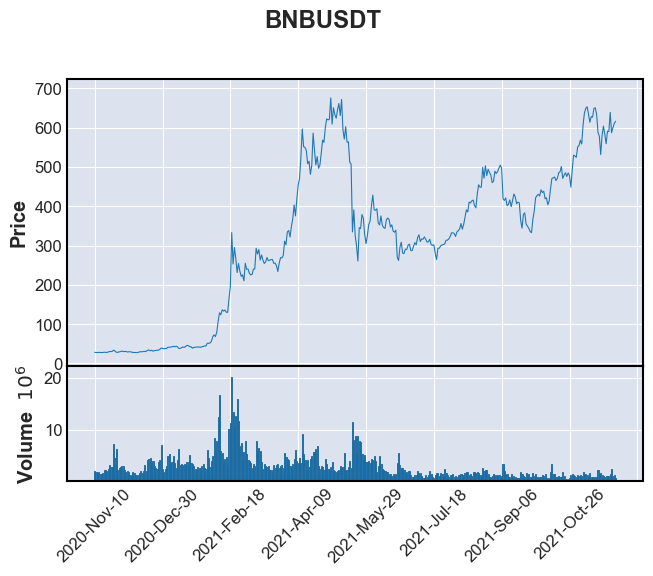

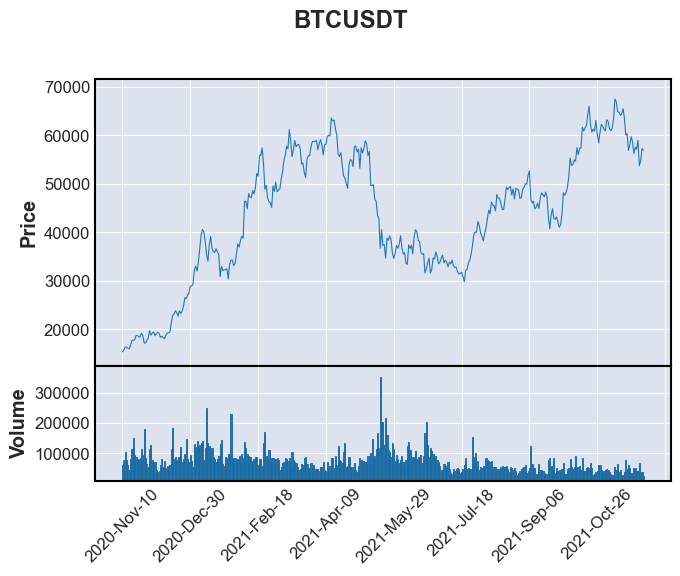

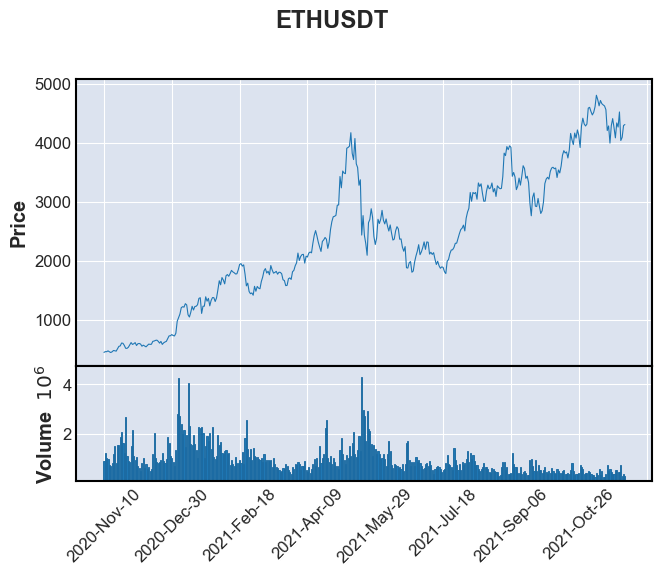

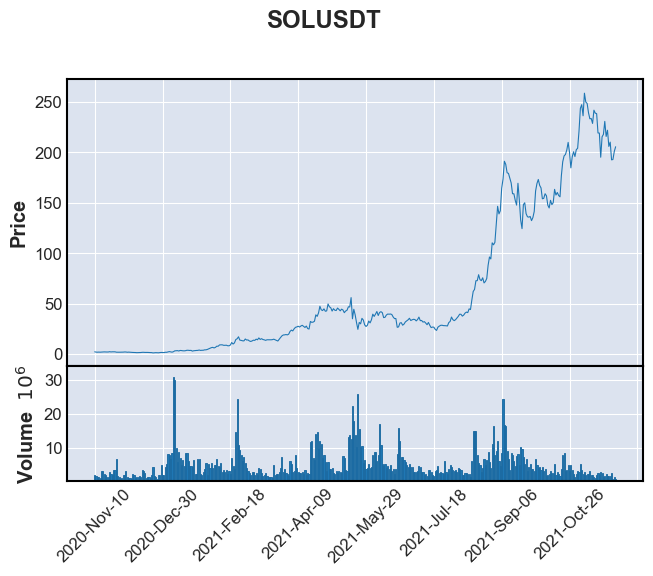

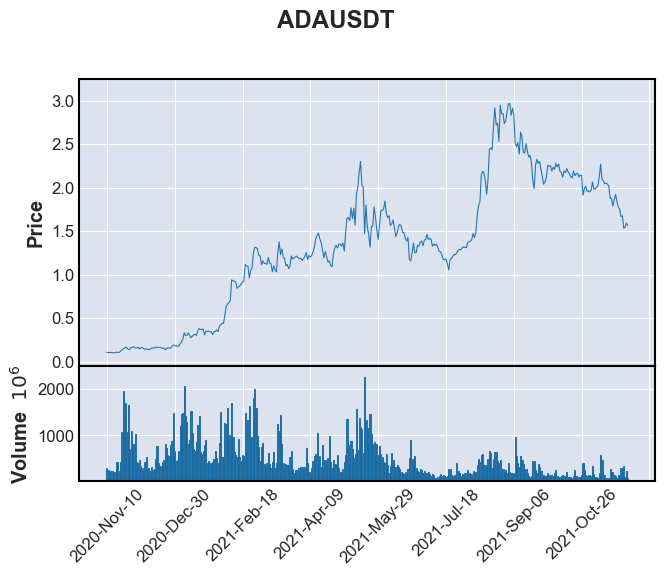

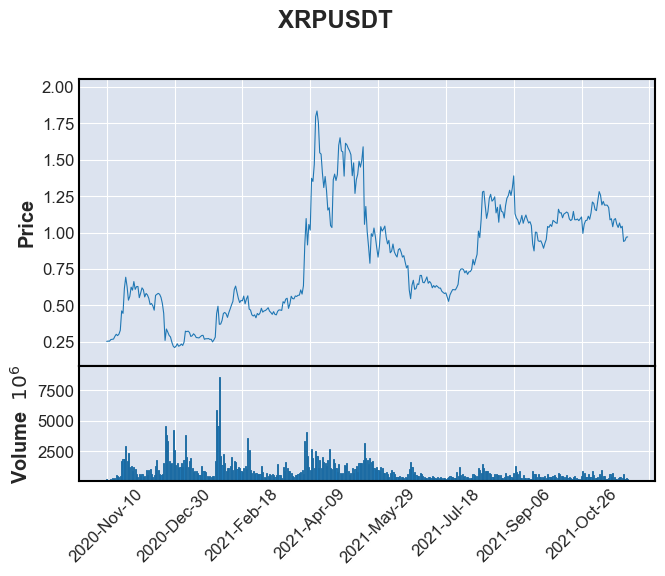

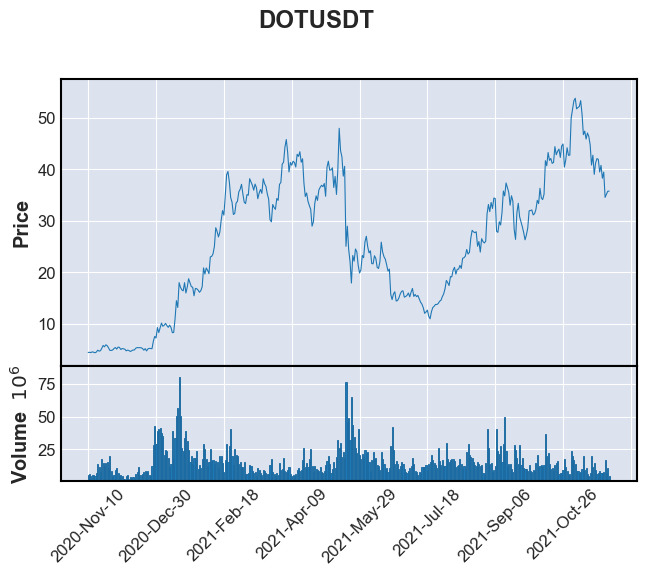

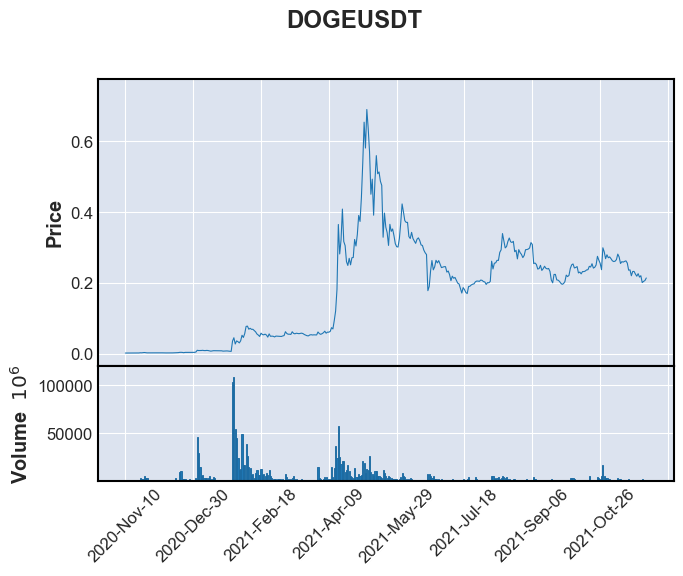

In [43]:
for asset in assets:    
    #mpl.plot(df[df['asset'] == asset], type='candle', volume=True, mav=7,title=asset)
    mpl.plot(df[df['asset'] == asset], type='line', volume=True,title=asset)

In [47]:
mu = {}
retornos = []
retornos_x = []

for asset in assets:
    lista = np.array(df[df['asset'] == asset]['Close'])
    retornos = (lista[1:]/lista[:-1])-1
    mu[asset] = np.average(retornos)
    retornos_x.append(retornos)
    #retornos_x = retornos_x.append(retornos)
x = np.vstack([retornos_x[0],retornos_x[1],retornos_x[2],retornos_x[3],retornos_x[4],retornos_x[5],retornos_x[6],retornos_x[7]])
sigma = np.cov(x)

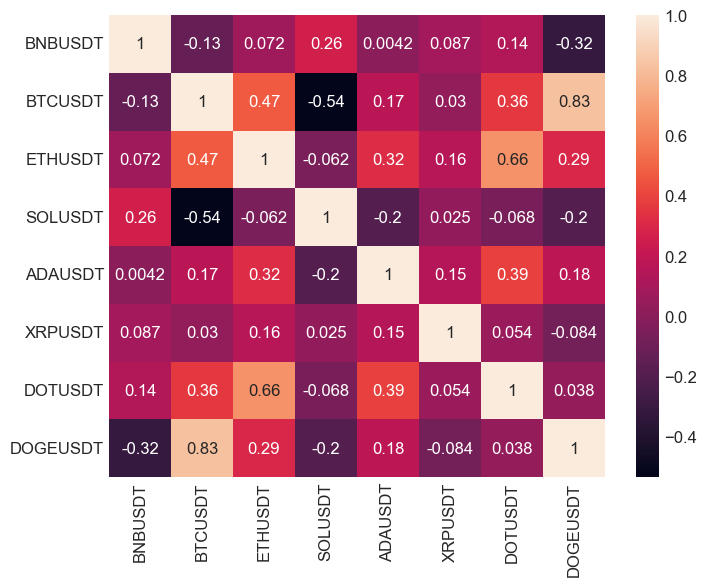

In [49]:
corr_df = pd.DataFrame(sigma).corr()
#corr_df.columns = assets
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True,xticklabels=assets, yticklabels=assets)
plt.show()

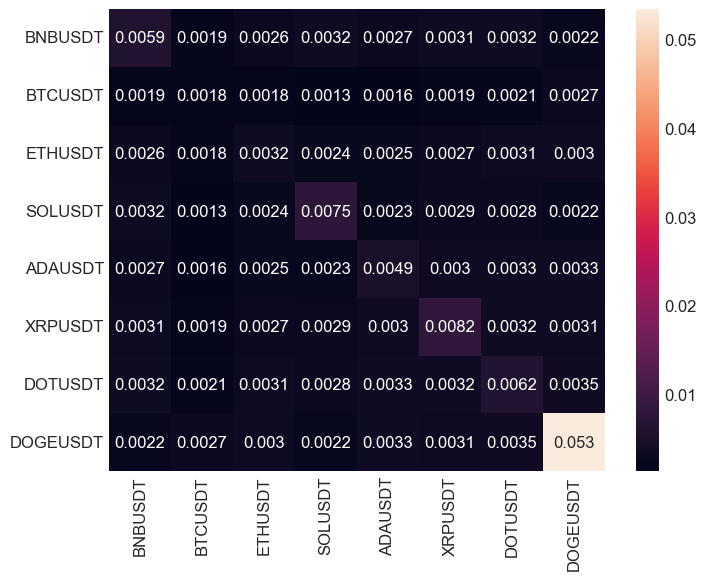

In [50]:
plt.figure(figsize=(8, 6))
sns.heatmap(sigma, annot=True,xticklabels=assets, yticklabels=assets)
plt.show()

In [62]:
num_assets = 8     
q = 0.1                   # set risk factor
budget = 4           # set budget as defined in the problem
seed = 132     #set random seed

portfolio = PortfolioOptimization([item for item in mu.values()],sigma,q,budget)
qp = portfolio.to_quadratic_program()

##############################
print(qp)

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Portfolio optimization

Minimize
 obj: - 0.010783892993 x_0 - 0.004319469808 x_1 - 0.007504141370 x_2
      - 0.015484493462 x_3 - 0.009379886863 x_4 - 0.007425375872 x_5
      - 0.008464811104 x_6 - 0.023231646769 x_7 + [ 0.001178722085 x_0^2
      + 0.000768507985 x_0*x_1 + 0.001029594398 x_0*x_2 + 0.001271839293 x_0*x_3
      + 0.001086380147 x_0*x_4 + 0.001224978753 x_0*x_5 + 0.001288953733 x_0*x_6
      + 0.000864951266 x_0*x_7 + 0.000358871096 x_1^2 + 0.000726477996 x_1*x_2
      + 0.000532403220 x_1*x_3 + 0.000656412209 x_1*x_4 + 0.000749739428 x_1*x_5
      + 0.000845872113 x_1*x_6 + 0.001088161761 x_1*x_7 + 0.000641219376 x_2^2
      + 0.000955535121 x_2*x_3 + 0.000989055828 x_2*x_4 + 0.001068647495 x_2*x_5
      + 0.001252759227 x_2*x_6 + 0.001188536230 x_2*x_7 + 0.001501281105 x_3^2
      + 0.000904330566 x_3*x_4 + 0.001155537773 x_3*x_5 + 0.001114534422 x_3*x_6
      + 0.000885333086 x_3*x_7 + 0.

In [63]:
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)
result = exact_eigensolver.solve(qp)

In [64]:
assets

['BNBUSDT',
 'BTCUSDT',
 'ETHUSDT',
 'SOLUSDT',
 'ADAUSDT',
 'XRPUSDT',
 'DOTUSDT',
 'DOGEUSDT']

In [65]:
result

optimal function value: -0.048540269814676615
optimal value: [1. 0. 0. 1. 1. 0. 0. 1.]
status: SUCCESS

In [66]:
###VQE###

optimizer = SLSQP(maxiter=1000)  
algorithm_globals.random_seed = 1234
backend = Aer.get_backend('statevector_simulator')

vqe = VQE(optimizer=optimizer, quantum_instance=backend)

vqe_meo = MinimumEigenOptimizer(vqe)
result = vqe_meo.solve(qp)

print(result)  

optimal function value: -0.04725826685279608
optimal value: [1. 0. 0. 1. 0. 0. 1. 1.]
status: SUCCESS


In [67]:
##QAOA

portfolio = PortfolioOptimization(expected_returns=[item for item in mu.values()], covariances=sigma, risk_factor=q, budget=budget,bounds=[[0,2],[0,2],[0,2],[0,2],[0,2],[0,2],[0,2],[0,2]])
#portfolio = PortfolioOptimization(expected_returns=[item for item in mu.values()], covariances=sigma, risk_factor=q, budget=budget)

qp2 = portfolio.to_quadratic_program()
qp2

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Portfolio optimization

Minimize
 obj: - 0.010783892993 x_0 - 0.004319469808 x_1 - 0.007504141370 x_2
      - 0.015484493462 x_3 - 0.009379886863 x_4 - 0.007425375872 x_5
      - 0.008464811104 x_6 - 0.023231646769 x_7 + [ 0.001178722085 x_0^2
      + 0.000768507985 x_0*x_1 + 0.001029594398 x_0*x_2 + 0.001271839293 x_0*x_3
      + 0.001086380147 x_0*x_4 + 0.001224978753 x_0*x_5 + 0.001288953733 x_0*x_6
      + 0.000864951266 x_0*x_7 + 0.000358871096 x_1^2 + 0.000726477996 x_1*x_2
      + 0.000532403220 x_1*x_3 + 0.000656412209 x_1*x_4 + 0.000749739428 x_1*x_5
      + 0.000845872113 x_1*x_6 + 0.001088161761 x_1*x_7 + 0.000641219376 x_2^2
      + 0.000955535121 x_2*x_3 + 0.000989055828 x_2*x_4 + 0.001068647495 x_2*x_5
      + 0.001252759227 x_2*x_6 + 0.001188536230 x_2*x_7 + 0.001501281105 x_3^2
      + 0.000904330566 x_3*x_4 + 0.001155537773 x_3*x_5 + 0.001114534422 x_3*x_6
      + 0.000885333086 x_3*x_7 + 0.

In [68]:
assets

['BNBUSDT',
 'BTCUSDT',
 'ETHUSDT',
 'SOLUSDT',
 'ADAUSDT',
 'XRPUSDT',
 'DOTUSDT',
 'DOGEUSDT']

In [69]:
algorithm_globals.massive=True

optimizer = SLSQP(maxiter=1000)  
algorithm_globals.random_seed = 1234
backend = Aer.get_backend('qasm_simulator')

quantum_instance = QuantumInstance(backend=backend, seed_simulator=1234, seed_transpiler=1234)
qaoa = QAOA(optimizer=optimizer,quantum_instance=backend)

qaoa_meo = MinimumEigenOptimizer(qaoa)

result2 = qaoa_meo.solve(qp2)  

print(result2) 

optimal function value: -0.05346198262331728
optimal value: [1. 0. 0. 2. 0. 0. 0. 1.]
status: SUCCESS
